In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pwd

'/content'

In [3]:
cd ..

/


In [4]:
cd content/drive/My Drive/Projects_content/AV_Innoplex_NLP_sentiment_Analysis

/content/drive/My Drive/Projects_content/AV_Innoplex_NLP_sentiment_Analysis


In [0]:
from fastai.text import *
from fastai.callbacks import *
import numpy as np
import pandas as pd
from tqdm import tqdm

In [0]:
seed = 7
np.random.seed(seed)
output_dir = 'model_output_fastai'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [7]:
data = pd.read_csv('TrainSet/train_F3WbcTw.csv')
data.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [8]:
test_df = pd.read_csv('TestSet/test_tOlRoBf.csv')
test_df.head()

,unique_hash,text,drug
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara


In [9]:
data['text'][4]

'Hi everybody, My latest MRI results for Brain and Cervical Cord are in and my next Neurologist appointment is in the next couple of weeks. There’re no new lesions in Brain/Cord and I’ve had no relapses while I was on Gilenya. This was a good sign. But there was one line in the cervical cord review that concerned me. It goes : “Lesions at C2-3 and T2 now show hypointensity on the post gadolinium T1 images only. This could represent artifact or early axonal loss.” That was bothersome to read. What are the kind of symptoms from C2-C3 lesion should I be aware of ? Would it result in change of my DMT ? Thanks.'

In [10]:
sample_df = pd.read_csv('sampleSub/sample_submission_i5xnIZD.csv')
sample_df.head()

,unique_hash,sentiment
0,9e9a8166b84114aca147bf409f6f956635034c08,0
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,0
2,50b6d851bcff4f35afe354937949e9948975adf7,0
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,0
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,0


In [11]:
pwd

'/content/drive/My Drive/Projects_content/AV_Innoplex_NLP_sentiment_Analysis'

In [12]:
data_lm = (TextList.from_csv(path='TrainSet/',csv_name='train_F3WbcTw.csv',cols='text')
       .split_by_rand_pct()
       .label_for_lm()
       .databunch(bs=16)
       )
data_lm.save('tmp_lm')
data_lm.show_batch()

idx,text
0,") and i do n’t know if it will last a month , a year , a decade , i ve just decided to enjoy the ride , no point in worrying . xxbos i can completely understand why you ’d want to try it . xxmaj but , results reported in xxunk do n’t always stand up to the xxunk of peer - review during publication . xxmaj there"
1,"xxmaj greetings everyone . xxmaj newbie here . i was diagnosed xxup nsclc in xxmaj december 2017 when a lung mass was discovered on a xxup pet scan which was done for a workup of a xxup gyn malignancy . i had no symptoms . a mass of 1.5 by 2 cm in my r lung with hilar and xxunk nodes , a xxunk node , and xxunk nodes ."
2,"useful when discussing treatment options with your healthcare provider and advocating with insurers for access and coverage . xxmaj this paper was last updated in 2016 . xxmaj adhering to your disease - modifying medication is a key element of treatment effectiveness . xxmaj for help in managing the costs of these medications , read about the patient assistance programs offered by the pharmaceutical companies . xxmaj under certain circumstances"
3,". xxmaj the new packaging has xxunk praise for not only being simple to use , but also xxunk . xxmaj the applicator is actually the product ’s cap , and comes in the form of a pull / push mechanism made from plastic . xxmaj according to xxup gsk global packaging development manager xxmaj xxunk xxmaj xxunk , the nature of this mechanism helps reduce xxunk risks , as"
4,an anti - xxup tnf drug for treatment of perianal fistula or intestinal xxmaj crohn 's ... xxmaj added 9 months ago xxmaj study xxmaj to xxmaj test xxmaj whether xxup pf-00547659 xxmaj is xxmaj safe xxmaj and xxmaj improves xxmaj disease xxmaj symptoms xxmaj in xxmaj patients xxmaj with xxmaj crohn 's xxmaj disease ( xxup opera ) xxmaj adults with xxmaj crohn 's disease that is clinically active


In [13]:
test_datalist = TextList.from_csv(path='TestSet/',csv_name='test_tOlRoBf.csv',cols='text',vocab=data_lm.vocab)
data_classifier = (TextList.from_csv(path='TrainSet/',csv_name='train_F3WbcTw.csv',cols='text',vocab=data_lm.vocab)
       .split_by_rand_pct()
       .label_from_df(cols='sentiment')
       .add_test(test_datalist)
       .databunch(bs=32)
       )
data_classifier.show_batch()

text,target
"xxbos xxmaj written xxmaj january 12 , 2018 xxmaj next : xxmaj let xxmaj us xxmaj try xxmaj home xxmaj ratings xxmaj rate this xxmaj summary xxmaj current xxmaj average xxmaj ratings xxmaj overall quality xxmaj avg : 0 / 5 xxmaj applies to topic xxmaj avg : 0 / 5 xxmaj helpful to me xxmaj avg : 0 / 5 xxmaj underwhelmed xxmaj total xxmaj avg xxmaj rating :",2
xxbos m protein xxmaj an antibody or part of an antibody found in unusually large amounts in the blood or urine of people with multiple myeloma and other types of plasma cell tumors . xxmaj also called monoclonal protein . m - xxup xxunk xxmaj minocycline - xxup xxunk . a substance being studied in the treatment of bacterial infections from catheters ( flexible tubes used to deliver fluids into,2
"xxbos xxmaj the lungs are a pair of cone - shaped breathing organs in the chest . xxmaj the lungs bring oxygen into the body as you breathe in . xxmaj they release carbon dioxide , a waste product of the body ’s cells , as you breathe out . xxmaj each lung has sections called lobes . xxmaj the left lung has two lobes . xxmaj the right lung",2
xxbos . xxmaj immunotherapy . xxmaj checkpoint inhibitors . xxmaj anti – programmed cell death-1 ( xxup pd-1 ) and programmed death - ligand 1 ( xxup pd - xxup l1 ) . xxmaj pembrolizumab . xxmaj nivolumab . xxmaj anti – cytotoxic t - lymphocyte antigen-4 ( xxup ctla-4 ) . xxmaj ipilimumab . xxmaj high - dose interleukin-2 ( xxup il-2 ) . xxmaj dual immunomodulation . xxmaj,2
xxbos xxmaj childhood rhabdomyosarcoma is a disease in which malignant ( cancer ) cells form in muscle tissue . xxmaj certain genetic conditions increase the risk of childhood rhabdomyosarcoma . a sign of childhood rhabdomyosarcoma is a lump or swelling that keeps getting bigger . xxmaj diagnostic tests and a biopsy are used to detect ( find ) and diagnose childhood rhabdomyosarcoma . xxmaj certain factors affect prognosis ( chance,2


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 2.09E-02


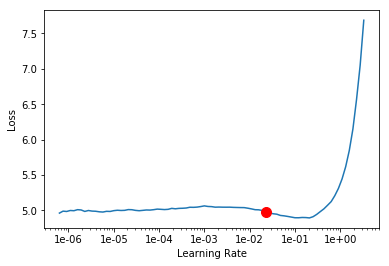

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

Max_acc = 0.367909 with lr = 1e-2 and moms

In [16]:
learn.fit_one_cycle(5, 1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.959155,3.756812,0.322613,07:14
1,3.724066,3.722498,0.328682,07:14
2,3.721837,3.595104,0.344448,07:14
3,3.400581,3.483469,0.361072,07:14
4,3.150612,3.464014,0.365568,07:14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.00E-04


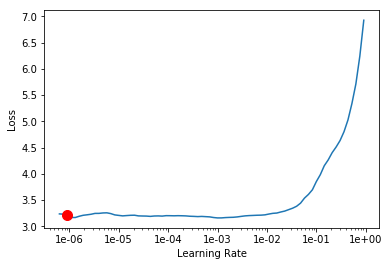

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [18]:
learn.fit_one_cycle(10, 1e-3,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.094923,3.359174,0.377448,08:23
1,2.724199,3.282258,0.395085,08:23
2,2.947337,3.234455,0.404565,08:23
3,2.678552,3.188808,0.418234,08:23
4,2.720833,3.147860,0.428448,08:23
5,2.576902,3.127960,0.436032,08:23
6,2.442683,3.119773,0.442839,08:23
7,2.026323,3.138744,0.445712,08:24


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_classifier, AWD_LSTM, drop_mult=0.2)
learn.load_encoder('ft_enc')
# learn.callback_fns = [ShowGraph,partial(SaveModelCallback, monitor='accuracy', name='best_model')]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 3.02E-02


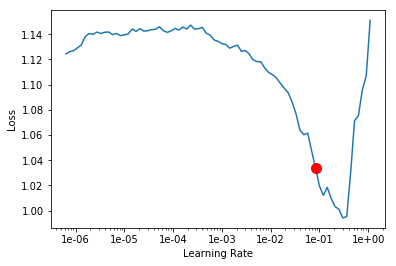

In [21]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [22]:
lr = 1e-2
learn.fit_one_cycle(3,slice(lr), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.762733,0.784385,0.686256,03:22
1,0.682997,0.722154,0.714692,03:26
2,0.607554,0.729775,0.722275,03:19


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.00E-04


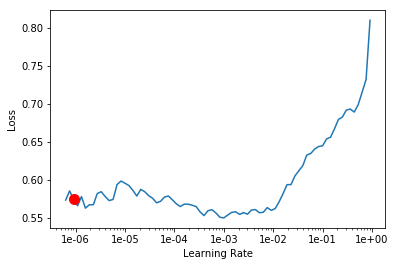

In [23]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion = True)

learn.fit_one_cycle(3, slice(5e-5/2., 5e-5),moms=(0.8,0.7))

learn.fit_one_cycle(3, slice(5e-5/(2.6**4), 5e-5),moms=(0.8,0.7)) -- Max_Acc:0.725118

In [24]:
learn.fit_one_cycle(3, slice(5e-5/(2.6**4), 5e-5),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.569552,0.728988,0.723223,03:31
1,0.553644,0.716168,0.719431,03:33
2,0.548735,0.707922,0.729858,03:29


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.92E-07


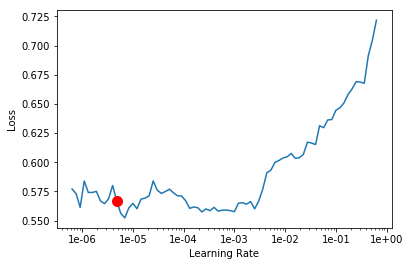

In [25]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion = True)

learn.fit_one_cycle(3, slice(5e-5/2., 5e-5),moms=(0.8,0.7)) max_acc = 0.742180

In [26]:
learn.fit_one_cycle(3, slice(5e-5/(2.6**4), 5e-5),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.554439,0.721589,0.723223,04:29
1,0.559168,0.718459,0.728910,04:22
2,0.551618,0.720999,0.725118,04:18


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


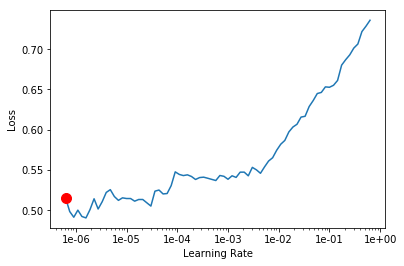

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

Unfreeze:
learn.fit_one_cycle(5, slice(2e-5/100, 2e-5),moms=(0.8,0.7)) max_acc = 0.734597	

In [28]:
learn.fit_one_cycle(5, slice(2e-5/(2.6**4), 2e-5),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.545002,0.724820,0.727014,05:13
1,0.539673,0.725483,0.726066,05:06
2,0.524752,0.729635,0.721327,05:06
3,0.544111,0.725328,0.727962,05:09
4,0.532222,0.719031,0.726066,05:06


In [0]:
# learn.load('best_model')

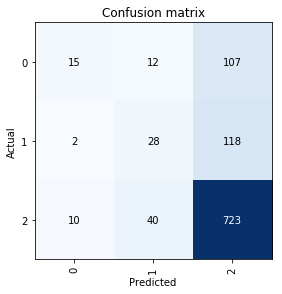

In [30]:
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.plot_confusion_matrix()

In [0]:
preds, target = learn.get_preds(DatasetType.Valid, ordered=True)
valid_preds = np.argmax(preds, axis =1)

Version3 F1 Score : 0.440700

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

learn.fit_one_cycle(5, 1e-2,moms=(0.8,0.7))

Unfreeze and learn.fit_one_cycle(10, 1e-3,moms=(0.8,0.7))

learn = text_classifier_learner(data_classifier, AWD_LSTM, drop_mult=0.2)

freeze
lr = 1e-2
learn.fit_one_cycle(3,slice(lr), moms=(0.8, 0.7))

Freeze_to(-2)
learn.fit_one_cycle(3, slice(5e-5/(2.6**4), 5e-5),moms=(0.8,0.7))

Freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-5/(2.6**4), 5e-5),moms=(0.8,0.7))

unfreeze
learn.fit_one_cycle(5, slice(2e-5/(2.6**4), 2e-5),moms=(0.8,0.7))

In [32]:
from sklearn.metrics import f1_score
# f1 score
score = f1_score(valid_preds, target,average='macro')

# print
print ("F1 score: {:.6f}".format(score))

F1 score: 0.424053


In [33]:
pd.crosstab(valid_preds, target)

col_0,0,1,2
row_0,,,
0,15,2,10
1,12,28,40
2,107,118,723


In [0]:
preds, target = learn.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)

In [0]:
test_id = test_df['unique_hash']

In [36]:
submission = pd.DataFrame({'unique_hash': test_id, 'sentiment': labels})
submission.to_csv('submission.csv', index=False)
submission.head()

,unique_hash,sentiment
0,9e9a8166b84114aca147bf409f6f956635034c08,2
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,1
2,50b6d851bcff4f35afe354937949e9948975adf7,2
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,2
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,2


In [37]:
submission['sentiment'].value_counts()

2    2695
1     180
0      49
Name: sentiment, dtype: int64

In [38]:
learn.show_results()

text,target,prediction
xxbos xxup serious xxup infections xxmaj patients treated with xxmaj remicade ® are at increased risk for developing serious infections that may lead to hospitalization or death [ see xxmaj warnings and xxmaj precautions ( 5.1 ) and xxmaj adverse xxmaj reactions ( 6.1 ) ] . xxmaj most patients who developed these infections were taking concomitant immunosuppressants such as methotrexate or corticosteroids . xxmaj remicade should be discontinued if,2,2
"xxbos xxmaj written xxmaj january 12 , 2018 xxmaj next : xxmaj let xxmaj us xxmaj try xxmaj home xxmaj ratings xxmaj rate this xxmaj summary xxmaj current xxmaj average xxmaj ratings xxmaj overall quality xxmaj avg : 0 / 5 xxmaj applies to topic xxmaj avg : 0 / 5 xxmaj helpful to me xxmaj avg : 0 / 5 xxmaj underwhelmed xxmaj total xxmaj avg xxmaj rating :",2,2
"xxbos xxmaj genetically - modified neural stem cells ( xxunk ) xxunk with the xxmaj escherichia coli ( xxup e. coli ) suicidal gene cytosine deaminase ( xxup cd ) , with potential antineoplastic adjuvant activity . xxmaj upon xxunk injection , xxup e. coli xxup cd - expressing genetically modified xxunk express the xxup e. coli cytosine deaminase , an enzyme that catalyzes the intracellular conversion of the xxunk",2,2
"xxbos xxunk : a xxmaj urine xxup dna xxmaj methylation xxmaj test for xxmaj early xxmaj detection of xxmaj aggressive xxmaj prostate xxmaj cancer xxup e. o'reilly et al , xxup xxunk xxmaj precision xxmaj oncology , xxmaj january 2019 xxmaj using xxmaj artificial xxmaj intelligence to xxmaj detect xxmaj cervical xxmaj cancer xxup nih xxmaj director 's xxmaj blog , xxmaj january 17 , 2019 xxmaj cancer surgery in",2,2
"xxbos ( in xxup fliks e mab ) xxmaj index xxmaj terms xxmaj avakine xxmaj infliximab , xxmaj recombinant xxmaj infliximab - abda xxmaj infliximab - dyyb xxmaj infliximab - qbtx xxmaj ixifi xxmaj dosage xxmaj forms xxmaj excipient information presented when available ( limited , particularly for generics ) ; consult specific product labeling . xxmaj solution xxmaj reconstituted , xxmaj intravenous : xxmaj inflectra : infliximab - dyyb",2,2


In [0]:
interp = TextClassificationInterpretation.from_learner(learn) 

In [40]:
interp.show_intrinsic_attention("Hi everybody, My latest MRI results for Brain and Cervical Cord are in and my next Neurologist appointment is in the next couple of weeks. There’re no new lesions in Brain/Cord and I’ve had no relapses while I was on Gilenya. This was a good sign. But there was one line in the cervical cord review that concerned me. It goes : “Lesions at C2-3 and T2 now show hypointensity on the post gadolinium T1 images only. This could represent artifact or early axonal loss.” That was bothersome to read. What are the kind of symptoms from C2-C3 lesion should I be aware of ? Would it result in change of my DMT ? Thanks.")

In [41]:
learn.predict("Hi everybody, My latest MRI results for Brain and Cervical Cord are in and my next Neurologist appointment is in the next couple of weeks. There’re no new lesions in Brain/Cord and I’ve had no relapses while I was on Gilenya. This was a good sign. But there was one line in the cervical cord review that concerned me. It goes : “Lesions at C2-3 and T2 now show hypointensity on the post gadolinium T1 images only. This could represent artifact or early axonal loss.” That was bothersome to read. What are the kind of symptoms from C2-C3 lesion should I be aware of ? Would it result in change of my DMT ? Thanks.")

(Category 2, tensor(2), tensor([0.1080, 0.3315, 0.5605]))

In [0]:
# for unique_id in tqdm(test_df['unique_hash'].values):
# #   print(unique_id)
#   filter = test_df["unique_hash"]==unique_id
#   df = test_df.where(filter)  
#   pred = learn.predict(df['text'][0])
# #   print(pred[0])
#   sample_df['sentiment'][sample_df['unique_hash'] == unique_id] = pred[0]
# #   print(type(pred))
# #   break
  
# sample_df.head()

In [0]:
# sample_df['sentiment'].value_counts()

In [0]:
# sample_df.to_csv(output_dir+r'/Submission_fastai_v2.csv',index=False)